In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=1)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=1) 
        self.bn8 = nn.BatchNorm2d(256)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))

        x = self.relu(self.bn7(self.conv7(x)))
        x = self.relu(self.bn8(self.conv8(x)))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
train_dataset = datasets.ImageFolder(root='../../dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='../../dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
memory_allocated = []
memory_reserved = []

In [7]:
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = torch.amp.GradScaler()

start = torch.cuda.Event(enable_timing=True)
start.record()

num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'): 
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        if torch.cuda.is_available():
            memory_allocated.append(torch.cuda.memory_allocated(device) / 1e6)  # Convert to MB
            memory_reserved.append(torch.cuda.memory_reserved(device) / 1e6)    # Convert to MB

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.9444
Epoch [2/10], Loss: 0.5009
Epoch [3/10], Loss: 0.3452
Epoch [4/10], Loss: 0.2693
Epoch [5/10], Loss: 0.2239
Epoch [6/10], Loss: 0.1923
Epoch [7/10], Loss: 0.1633
Epoch [8/10], Loss: 0.1633
Epoch [9/10], Loss: 0.1376
Epoch [10/10], Loss: 0.1152


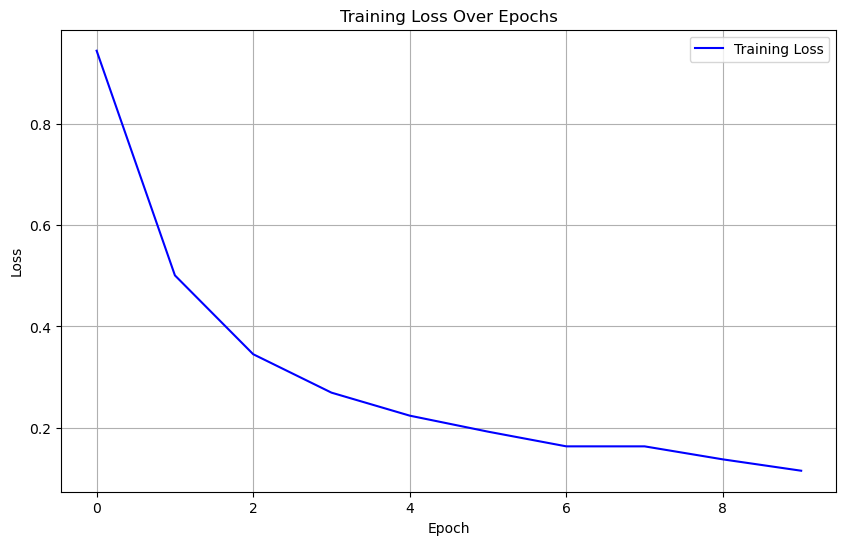

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [9]:
end = torch.cuda.Event(enable_timing=True)
end.record()

torch.cuda.synchronize()
print(f"Total Time (in mins) elapsed: {(start.elapsed_time(end) / 60000):.2f}")

Total Time (in mins) elapsed: 14.28


In [10]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast('cuda'): 
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Custom CNN Test Accuracy: {accuracy:.2f}")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Custom CNN Test Accuracy: 0.95
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.99      0.97       100
                     Pepper__bell___healthy       1.00      0.80      0.89       148
                      Potato___Early_blight       0.97      0.99      0.98       100
                       Potato___Late_blight       0.91      0.97      0.94       100
                           Potato___healthy       0.35      0.94      0.51        16
                      Tomato_Bacterial_spot       0.95      0.99      0.97       213
                        Tomato_Early_blight       0.96      0.92      0.94       100
                         Tomato_Late_blight       0.99      0.85      0.91       191
                           Tomato_Leaf_Mold       0.95      0.96      0.95        96
                  Tomato_Septoria_leaf_spot       0.94      0.96      0.95       178
Tomato_Spider_mites_Two_spotted_s

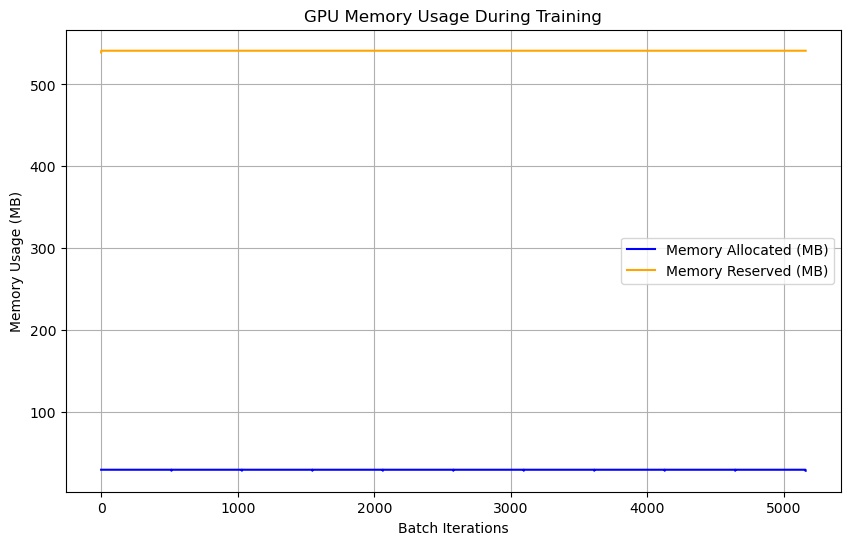

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(memory_allocated, label="Memory Allocated (MB)", color='blue')
plt.plot(memory_reserved, label="Memory Reserved (MB)", color='orange')
plt.xlabel("Batch Iterations")
plt.ylabel("Memory Usage (MB)")
plt.title("GPU Memory Usage During Training")
plt.legend()
plt.grid()
plt.show()